In [ ]:
%matplotlib inline

import cv2
import json
import tensorflow as tf
import numpy as np

from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt

In [ ]:
labels = json.load(open('../data/label.json', 'r'))

In [100]:
img_path = '../data/images'

images = []
# for f in listdir(img_path):
#     if isfile(join(img_path, f)):
for f in labels:
    img_name = labels[str(f)]['label']
    img = cv2.imread('{}/{}_{}.jpg'.format(img_path, f, img_name), cv2.IMREAD_GRAYSCALE)
#         img = cv2.imread(join(img_path, f), cv2.IMREAD_GRAYSCALE)
#         plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    images.append(img)

In [115]:
def create_sparse(batch_size, images, labels, dtype=np.character):
    indices = []
    values = []
    
    sample_index = np.random.choice(len(images), size=batch_size)
    sample_images = []
    
    x_max = 0
    y_max = 0

    for key, index in zip(sample_index, range(batch_size)):
        sample = labels[str(key)]
        length = sample['length']
        label = sample['label']
        
        img = images[key]
        x_max = max(x_max, img.shape[0])
        y_max = max(y_max, img.shape[1])

        sample_images.append(img)

        for number, number_index in zip(label, range(length)):
            indices.append((index, number_index))
            values.append(number)

    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([batch_size, np.asarray(indices).max(0)[1] + 1], dtype=np.int64)

    return indices, values, shape, sample_images, x_max, y_max

In [137]:
indices, values, shape, sample_images, x_max, y_max = create_sparse(32, images, labels)

In [146]:
def add_padding_to_images(x_max, y_max, images):

    output = []
    for img in images:
        left_pad = int((x_max - img.shape[0]) / 2)
        right_pad = x_max - img.shape[0] - int((x_max - img.shape[0]) / 2)
        top_pad = int((y_max - img.shape[1]) / 2)
        bottom_pad = y_max - img.shape[1] - int((y_max - img.shape[1]) / 2)

        img = np.pad(img, 
                     pad_width=((left_pad, right_pad), 
                                (top_pad, bottom_pad)), 
                     mode='constant', 
                     constant_values=0)
        
        output.append(img)
        
    return np.array(output)

In [147]:
sample_images = add_padding_to_images(x_max, y_max, sample_images)

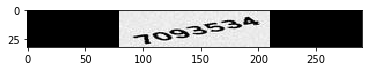

In [151]:
plt.imshow(sample_images[0], cmap='gray', vmin=0, vmax=255)

In [106]:
values[:5]

array([b'3', b'1', b'5', b'5', b'9'],
      dtype='|S1')

In [ ]:
n_features = 32
n_rnn_layers = 1
n_rnn_units = 128

In [ ]:
graph = tf.Graph()

with graph.as_default():
    inputs = tf.placeholder(tf.float32, [None, None, n_features])
    targets = tf.sparse_placeholder(tf.int32)
    seq_len = tf.placeholder(tf.int32, [None])
    
    cells = []
    for _ in range(n_rnn_layers):
        cell = tf.contrib.rnn.LSTMCell(n_rnn_units)
        cells.append(cell)
    stack = tf.contrib.rnn.MultiRNNCell(cells)

    outputs, _ = tf.nn.dynamic_rnn(stack, inputs, seq_len, dtype=tf.float32)
    

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())